# As NBr25, but without NONE (0 0 0) node

In [1]:
from WS_Mdl.utils import Sign, Pre_Sign
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM
import WS_Mdl.geo as G
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import shutil as sh
import re
from datetime import datetime as DT
from typing import Optional, Dict
import rasterio
from rasterio.transform import from_bounds
import imod
import numpy as np
import xarray as xr
from pathlib import Path
import pandas as pd
pd.set_option('display.max_rows', 30)      # show up to 30 rows
import geopandas as gpd
from shapely.geometry import Point as Pt
from concurrent.futures import ProcessPoolExecutor as PPE
import zipfile as ZF
import xml.etree.ElementTree as ET
import sys
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import importlib as IL
IL.reload(U)
IL.reload(G)

<module 'WS_Mdl.geo' from 'C:\\Users\\Karam014\\OneDrive - Universiteit Utrecht\\WS_Mdl\\code\\WS_Mdl\\geo.py'>

# 1. Options.

In [3]:
MdlN, MdlN_B = 'NBr27', 'NBr18' # B is NBr17, but in this case it's only read to get the RIV block, so we need a Sim with a RIV block

In [4]:
JypNote_name = f'write_SFR_{MdlN}.ipynb'  # replace with __file__ when converted to .py
Pa_Ctmt = r'C:\OD\WS_Mdl\models\NBr\PoP\common\Pgn\Chaamse_beek\catchment_chaamsebeek_ulvenhout.shp'
Pa_TOP = r'C:\OD\WS_Mdl\models\NBr\In\TOP'
Pa_BOT = r'C:\OD\WS_Mdl\models\NBr\In\BOT'

In [5]:
d_Pa = U.get_MdlN_paths(MdlN)
d_Pa_B = U.get_MdlN_paths(MdlN_B)
Pa_SFR = PJ(d_Pa['Pa_Mdl'], f'In/SFR/{MdlN}/{MdlN}.SFR6')
MDs(PDN(Pa_SFR), exist_ok=True)  # Make dir for SFR file.

In [6]:
Xmin, Ymin, Xmax, Ymax, cellsize, N_R, N_C = U.Mdl_Dmns_from_INI(d_Pa_B['INI'])

🟢 - INI file C:/OD/WS_Mdl\models/NBr\code/Mdl_Prep/Mdl_Prep_NBr18.ini read successfully. Dictionary created with 21 keys.
🟢 - model dimensions extracted from C:/OD/WS_Mdl\models/NBr\code/Mdl_Prep/Mdl_Prep_NBr18.ini.


# 2. Load RIV to get params.

In [7]:
DF_full = UIM.PRJ_to_DF(MdlN_B)

 --- Reading PRJ Packages into DF ---
	(cap)  	...	🟢
	extra  	...	🟡
	(bnd)  	...	🟢
	(top)  	...	🟢
	(bot)  	...	🟢
	(khv)  	...	🟢
	(kva)  	...	🟢
	(shd)  	...	🟢
	(sto)  	...	🟢
	(spy)  	...	🟢
	(hfb)  	...	🟢
	(drn)  	...	🟢
	(riv)  	...	🟢
	(wel)  	...	🟢
	(pcg)  	...	🟡
	(chd)  	...	🟢
	periods	...	🟡
	species	...	🟡
🟢🟢🟢
 ----------------------------------------------------------------------------------------------------


In [8]:
DF = DF_full.copy().query(" (package == 'RIV') & (path==path) ")

# 3. Make an A of cells where we'll place SFR reaches.

## 3.0. Make a Series of As that show where each RIV IDF is active.

In [9]:
def active_A(Pa):
    IDF = imod.formats.idf.open(Pa)
    IDF = IDF.sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))
    return IDF.notnull().astype(int)

In [10]:
Se_active_A = DF['path'].apply(active_A)

## 3.1. Review the number of active cells

In [11]:
DF['shape'] = Se_active_A.apply(lambda x: x.shape)
DF['N_active_cells'] = Se_active_A.apply(lambda x: int(x.sum()))
DF['basename'] = DF['path'].apply(lambda x: PBN(x))
DF['system'] = DF['basename'].apply(lambda x: x.split('_')[2].lower())

In [12]:
l_Cs = ['parameter', 'time', 'shape', 'N_active_cells', 'system', 'basename']

In [13]:
for time in DF['time'].unique():
    print(DF.query('time == "summer"').loc[:, l_Cs].sort_values(['N_active_cells', 'parameter'], ascending=False).to_string(index=False))
    print('-'*100)

       parameter   time      shape  N_active_cells            system                            basename
     conductance summer (344, 480)           32355 detailwatergangen RIV_Cond_DETAILWATERGANGEN_NBr1.IDF
           stage summer (344, 480)           32074 detailwatergangen  RIV_Stg_Detailwatergangen_NBr1.IDF
bottom_elevation summer (344, 480)           32074 detailwatergangen  RIV_Stg_Detailwatergangen_NBr1.IDF
     conductance summer (344, 480)            7568               riv               RIV_Cond_RIV_NBr1.IDF
     conductance summer (344, 480)            7568               drn               RIV_Cond_DRN_NBr1.IDF
bottom_elevation summer (344, 480)            7568             river RIV_Bot_RIVER_RIVER_BOTTOM_NBr1.IDF
           stage summer   (35, 48)               1            summer             RIV_Stg_summer_NBr1.IDF
           stage summer   (35, 48)               1            summer             RIV_Stg_summer_NBr1.IDF
           stage summer   (35, 48)               1     

There are some dataset issues:
- N_active_cells differ between parts of the same system
- N_active_cells same across seasons, so summer file can be used for all.

Notes:
- Sys1 is detailwatergangen
- Sys2 and Sys3 main river
- Sys4 and Sys5 not important here
- Each parameter has 15 arrays (3 seasons x 5 systems)

Check how many cells are active in RIV/DRN but not in detailwatergangen (cond).

In [14]:
DF.query("basename == 'RIV_Cond_DRN_NBr1.IDF'")

,package,parameter,MdlN,time,active,is_constant,layer,factor,addition,constant,suffix,path,shape,N_active_cells,basename,system
(RIV)_conductance_Sys3_steady-state,RIV,conductance,NBr1,steady-state,True,2,0,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\RIV\RIV_Cond_DRN_NB...,"(344, 480)",7568,RIV_Cond_DRN_NBr1.IDF,drn
(RIV)_conductance_Sys3_winter,RIV,conductance,NBr1,winter,True,2,0,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\RIV\RIV_Cond_DRN_NB...,"(344, 480)",7568,RIV_Cond_DRN_NBr1.IDF,drn
(RIV)_conductance_Sys3_summer,RIV,conductance,NBr1,summer,True,2,0,1.0,0.0,-999.99,.idf,C:/OD/WS_Mdl\models\NBr\In\RIV\RIV_Cond_DRN_NB...,"(344, 480)",7568,RIV_Cond_DRN_NBr1.IDF,drn


Call them A1 and A2 for simplicity.

In [15]:
A1 = Se_active_A.iloc[0]
A2 = Se_active_A.iloc[1]

In [16]:
A3 = xr.where((A1==0) & (A2==1), 1, 0)
A4 = xr.where((A1==1) & (A2==1), 1, 0)
A5 = xr.where((A1==1) & (A2==0), 1, 0)

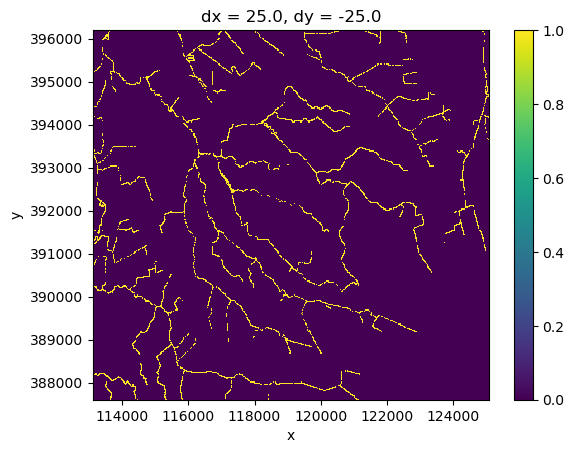

In [17]:
A3.plot()

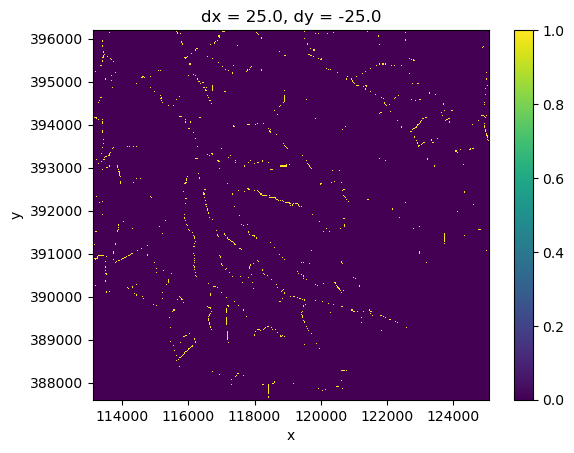

In [18]:
A4.plot()

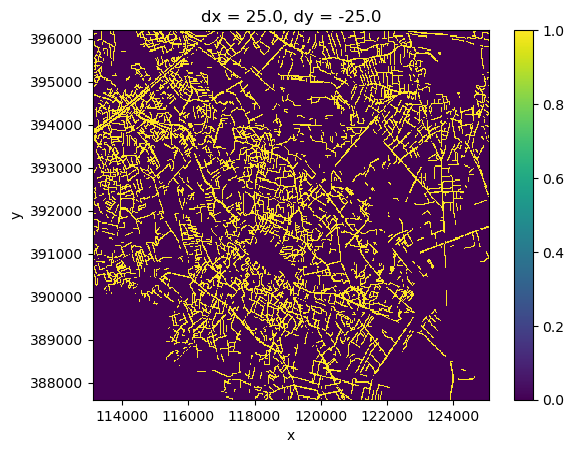

In [19]:
A5.plot()

In [20]:
A3.sum().values, A4.sum().values, A5.sum().values

(array(6304), array(1264), array(31091))

- Most main river cells aren't part of detailwatergangen
- Detailwatergangen not well connected, main river cells help connectivity
- For NBr17 all cells will be connected downstream
- Will create one SFR network for all nodes within catchment for routing simplicity

Better to use cells active in both cond and bot arrays, maybe same as bot array only. Check next.

In [21]:
Se_active_A.iloc[30:33].index.values, Se_active_A.iloc[0:3].index.values

(array(['(RIV)_bottom_elevation_Sys1_steady-state',
        '(RIV)_bottom_elevation_Sys2_steady-state',
        '(RIV)_bottom_elevation_Sys3_steady-state'], dtype=object),
 array(['(RIV)_conductance_Sys1_steady-state',
        '(RIV)_conductance_Sys2_steady-state',
        '(RIV)_conductance_Sys3_steady-state'], dtype=object))

In [22]:
A6 = xr.where((Se_active_A.iloc[31-1]==1) & (Se_active_A.iloc[1-1]==0), 1, 0)
A7 = xr.where((Se_active_A.iloc[32-1]==1) & (Se_active_A.iloc[2-1]==0), 1, 0)

In [23]:
print(f"""Number of active cells in the bot array that aren't active in the cond array.
            For detailwatergangen: {A6.sum().values}
            For RIV: {A7.sum().values}""")

Number of active cells in the bot array that aren't active in the cond array.
            For detailwatergangen: 0
            For RIV: 0


Both 0, so bot array covers all bottom cells; use bot array.

Check opposite direction

In [24]:
A8 = xr.where((Se_active_A.iloc[31-1]==0) & (Se_active_A.iloc[1-1]==1), 1, 0)
A9 = xr.where((Se_active_A.iloc[32-1]==0) & (Se_active_A.iloc[2-1]==1), 1, 0)

In [25]:
print(f"""Number of active cells in the cond array that aren't active in the bot array.
            For detailwatergangen: {A8.sum().values}
            For RIV: {A9.sum().values}""")

Number of active cells in the cond array that aren't active in the bot array.
            For detailwatergangen: 281
            For RIV: 0


Confirms plot of N_active columns.

## 3.2. Prep to write SFR blocks.

### 3.2.0. NREACHES

In [26]:
A = Se_active_A.iloc[30] | Se_active_A.iloc[31]

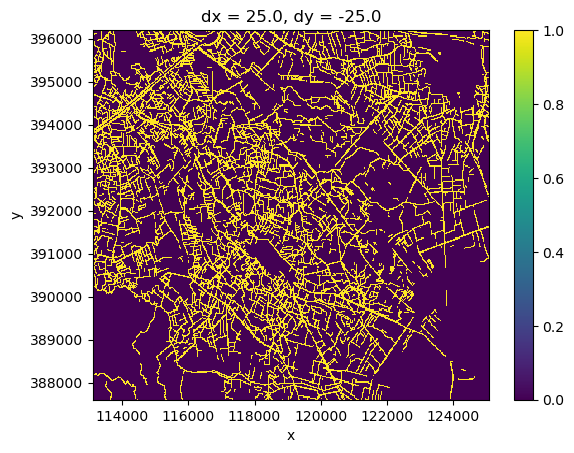

In [27]:
A.plot()

Check for any null values

In [28]:
n_nans = A.isnull().sum().compute().item()
if n_nans > 0:
    raise ValueError(f'There are {n_nans} null values in the active cells array.')

In [29]:
NREACHES = A.sum().values
NREACHES

array(38379)

### 3.2.1. PACKAGEDATA

In [ ]:
L = 1  # Will be improved to find correct layer
Rs, Cs = np.nonzero(A.values)
Xs, Ys = A['x'].values[Cs], A['y'].values[Rs]
Pts = [Pt(x, y) for x, y in zip(Xs, Ys)]

In [ ]:
A_rtp1 = imod.formats.idf.open(r'C:/OD/WS_Mdl\models\NBr\In\RIV\RIV_Bot_RIVER_RIVER_BOTTOM_NBr1.IDF').sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))
A_rtp2 = imod.formats.idf.open(r'C:/OD/WS_Mdl\models\NBr\In\RIV\NBr13\RIV_Stg_Detailwatergangen_NBr13.IDF').sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))

In [ ]:
# G.DA_stats(A_tp1)

In [ ]:
A_rtp1.plot()

In [ ]:
A_rtp2.plot()

Main rivers take priority over detailwatergangen for rtp.

In [ ]:
type(A_rtp1)

In [ ]:
# rtp_1 = A_rtp1.values[Rs, Cs]
# rtp_2 = A_rtp2.values[Rs, Cs]

In [ ]:
A_rtp_active = xr.where(np.isnan(A_rtp2), A_rtp1, A_rtp2)  # Use RIV/DRN bottoms if possible, else detailwatergangen

Cell above didn't work due to elevation conflicts.

#### Get correct Ls for each reach

l_TOP = [PJ(Pa_TOP, i) for i in LD(Pa_TOP) if ('idf' in i) and ('.dvc' not in i.lower())]
l_BOT = [PJ(Pa_BOT, i) for i in LD(Pa_BOT) if ('idf' in i) and ('.dvc' not in i.lower())]
TOP_100 = imod.formats.idf.open(l_TOP, pattern="{name}_L{layer}_").sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))
BOT_100 = imod.formats.idf.open(l_BOT, pattern="{name}_L{layer}_").sel(x=slice(Xmin, Xmax), y=slice(Ymax, Ymin))
**All reaches connected to L1, L1 top used as rtp. Will improve later.**
TOP = TOP_100.interp(y=A_rtp_active['y'], x=A_rtp_active['x'], method='linear', kwargs={'fill_value': 'extrapolate'})
BOT = BOT_100.interp(y=A_rtp_active['y'], x=A_rtp_active['x'], method='linear', kwargs={'fill_value': 'extrapolate'})

In [ ]:
Pa_BOT = r"C:\OD\WS_Mdl\models\NBr\Sim\NBr16\GWF_1\MODELINPUT\DIS6\BOTM_L1.IDF"

In [ ]:
BOT = imod.formats.idf.open(Pa_BOT) + 0.002 # adding thickness so that the river bed is barely inside L1.

In [ ]:
A_rtp = BOT.where(~np.isnan(A_rtp_active))
Se_rtp = A_rtp.stack(cell=('y','x')).dropna('cell').to_pandas().squeeze()

In [ ]:
type(Se_rtp)

#### Get correct L from TOP

---

valid_mask = ~np.isnan(A_rtp)

A_rtp_3D = A_rtp.where(valid_mask).expand_dims({'layer': TOP['layer']}, axis=0)

Cdt = (TOP >= A_rtp_3D) & (A_rtp_3D >= BOT)  # Check if layer bounds match

print(f"{NREACHES - Cdt.values.sum()} cells didn't match")

Check for multiple matches (should be impossible)

matches_per_cell = Cdt.sum(dim='layer')
multiple_matches = (matches_per_cell > 1)
if multiple_matches.any():
    print("Warning: some cells have multiple matching layers.")
else:
    print("No cells have multiple matching layers.")

Check cells without a match

no_match = (Cdt.sum(dim='layer') == 0)
valid_no_match = no_match & (~np.isnan(A_rtp))
rows, cols = np.where(valid_no_match.values)

for i, (r, c) in enumerate(zip(rows[:20], cols[:20])):
    ar_val = A_rtp.values[r, c]
    bot_vals = BOT.values[:, r, c]
    top_vals = TOP.values[:, r, c]
    print(f"Cell ({r},{c}): A_rtp={ar_val}")
    for l in range(len(bot_vals)):
        print(f"{i}  Layer {l}: BOT={bot_vals[l]}, TOP={top_vals[l]}")

Multiple unmatched cells found.

---

#### Make DF from params and write block

In [ ]:
DF_PD = pd.DataFrame({
    'ifno': np.arange(1, NREACHES),
    'L': L,
    'R': Rs+1,
    'C': Cs+1,
    'rlen': 25,
    'rwid': 2,
    'rgrd': 0.001,
    'rtp': Se_rtp,
    'rbth': 0.001,
    'rhk': 0.0001,
    'man': 0.03,
    'ncon': 1,
    'ustrf': 1,
    'ndv': 0,
    'aux': ['r' + str(i) for i in np.arange(1, NREACHES)],
    'X': Xs,
    'Y': Ys
})

### 3.2.2 CONNECTION

In [ ]:
GDF_Ctmt = gpd.read_file(Pa_Ctmt)
Pgn_Ctmt = GDF_Ctmt.geometry.union_all()

In [ ]:
DF_PD['geometry'] = Pts

In [ ]:
inside_mask = DF_PD['geometry'].apply(Pgn_Ctmt.contains)
DF_PD['Ctmt'] = 0
DF_PD.loc[inside_mask, 'Ctmt'] = 1

In [ ]:
d_outlets = {}

In [ ]:
for i in DF_PD['Ctmt'].unique(): # Get outflet index for catchment and outside catchment.
    subset = DF_PD[DF_PD['Ctmt'] == i]
    d_outlets[i] = subset[subset['rtp'] == subset['rtp'].min()]['ifno'].values[0]
d_outlets

In [ ]:
DF_PD['ic'] = DF_PD.apply(lambda r: -int(d_outlets[r['Ctmt']]) if r['ifno'] != d_outlets[r['Ctmt']] else np.nan, axis=1)

In [ ]:
mapping = { int(-k): v for k, v in DF_PD['ic'].value_counts().to_dict().items() }

In [ ]:
mapping = {k: (v+1) for k, v in mapping.items()}  # Remove NaN values # +1 for outflow reach (0 0 0)

In [ ]:
mask = DF_PD['ifno'].isin(mapping)

In [ ]:
DF_PD.loc[mask, 'ncon'] = DF_PD.loc[mask, 'ifno'] # replace the ncon values with ifno, so that they can then be raplaced by mapping. This is quite flawed, but works for now.

In [ ]:
DF_PD.loc[mask, 'ncon'] = DF_PD.loc[mask, 'ncon'].map(mapping)

2 missing values; others reference outlets as expected.

In [ ]:
DF_PD['ic'] = DF_PD['ic'].fillna(0).astype(int)

In [ ]:
#DF_PD_group = DF_PD.groupby('ic')['ifno'].apply(lambda s: ' '.join(s.astype(str))).rename('ic_outflow')

In [ ]:
#DF_PD_group.index = DF_PD_group.index*(-1)

In [ ]:
ifnos_to_replace = DF_PD.loc[DF_PD['ic'] == 0, 'ifno']

In [ ]:
lookup = {ifno: ' '.join(DF_PD.loc[DF_PD['ic'] == -ifno, 'ifno'].astype(str))
          for ifno in ifnos_to_replace}
DF_PD.loc[DF_PD['ic'] == 0, 'ic'] = DF_PD['ifno'].map(lookup)

In [ ]:
DF_PD_ = DF_PD.copy()

In [ ]:
DF_PD = DF_PD_.copy()

In [ ]:
DF_PD['ic'] = DF_PD['ic'].apply(lambda x: ' '.join(map(str, [f'-{NREACHES}'] + x.split(' '))) if hasattr(x, '__iter__') and isinstance(x, str) else str(x))

### 3.2.3. Add outflow point to PACKAGEDATA and CONNECTIONDATA

In [ ]:
DF_Out = DF_PD.iloc[-1].to_frame().T

In [ ]:
DF_Out['ifno'] +=1
DF_Out[['L', 'R', 'C']] = '', '', 'NONE'
DF_Out['rtp'] = DF_PD['rtp'].min() - 1

In [ ]:
DF_Out['ncon'] = 2 # One for outflow within catchment, he other for outflow outside catchment.
DF_Out['ic'] = ' '.join(list(str(i) for i in mapping.keys()))

In [ ]:
DF_Out['aux'] = '0_0_0'

In [ ]:
DF_PD = pd.concat([DF_PD, DF_Out])

In [ ]:
DF_Conn = DF_PD[['ifno', 'ic']]

## 3.3. Write SFR blocks

### 3.3.0. OPTIONS & DIMENSIONS

In [ ]:
with open(Pa_SFR, 'w') as f:
    f.write(f"# File created by {JypNote_name} for {MdlN} on {DT.now()}\n")
    f.write('BEGIN OPTIONS\n')
    f.write(f'\tOBS6 FILEIN ./GWF_1/MODELINPUT/{MdlN}.SFR.OBS6\n')
    # f.write(f'\tSAVE_FLOWS ./MODELINPUT/{MdlN}.SFR.OBS6\n')
    # f.write(f'\tSTAGE FILEOUT ./MODELINPUT/{MdlN}.SFR.OBS6\n')
    # f.write(f'\tSTAGE FILEOUT ./MODELINPUT/{MdlN}.SFR.OBS6\n')
    f.write('END OPTIONS\n\n')
    f.write('BEGIN DIMENSIONS\n')
    f.write(f'\tNREACHES {NREACHES}\n')
    f.write('END DIMENSIONS\n')

### 3.3.1. PACKAGEDATA

In [ ]:
with open(Pa_SFR, 'a') as f:
    f.write('\nBEGIN PACKAGEDATA\n')
    block = U.DF_to_MF_block(DF_PD[DF_PD.columns[:-3]], Min_width=4)
    f.write(block)
    f.write('END PACKAGEDATA\n')

### 3.3.2. CONNECTIONDATA

In [ ]:
with open(Pa_SFR, 'a', newline='') as f:
    f.write('\nBEGIN CONNECTIONDATA\n')
    f.write('#' + '\t'.join(DF_Conn.columns) + '\n')
    for _, row in DF_Conn.iterrows():
        f.write(f"{row['ifno']}\t{row['ic']}\n")
    f.write('END CONNECTIONDATA\n')

In [ ]:
with open(Pa_SFR, 'a', newline='') as f:
    f.write('\nBEGIN PERIOD 1\n')
    f.write('END PERIOD\n')